# **MultiModal RAG App for Video Processing With LlamaIndex and LanceDB**

### 1. llamaindex framework
### 2. Lancedb Vector DataBase
### 3. LLM MultiModAl GPT-4V or Google-gemini-pro-vision


# **Steps Need to follow:**
#### 1. Download video from YouTube, process and store it.

#### 2. Build Multi-Modal index and vector store for both texts and images.

#### 3. Retrieve relevant images and context, use both to augment the prompt.

#### 4. Using GPT4V for reasoning the correlations between the input query and augmented data and generating final response.

### 1. Loading relevant packages

In [1]:
# %pip install llama-index-vector-stores-lancedb
# %pip install llama-index-multi-modal-llms-openai
# %pip install llama-index-embeddings-clip
# %pip install git+https://github.com/openai/CLIP.git
# !pip install llama-index-readers-file

In [2]:
# %pip install llama_index
# %pip install -U openai-whisper

In [3]:
# %pip install lancedb
# %pip install moviepy
# %pip install yt_dlp
# # %pip uninstall pytube -y
# # %pip install git+https://github.com/pytube/pytube
# # %pip install pytube
# %pip install pydub
# %pip install SpeechRecognition
# %pip install ffmpeg-python
# %pip install soundfile
# %pip install torch torchvision
# %pip install matplotlib scikit-image
# %pip install ftfy regex tqdm

ffmpeg-library enables you to use FFmpeg in Python to manipulate various media files for different purposes like building comprehensive multimedia applications, preprocessing media files.

MoviePy is a Python library for video editing, enabling cutting, concatenations, title insertions, video compositing, and effects like animations or color grading.

Pytube is a Python library used for downloading videos from YouTube. It supports downloading in various formats, resolutions, and also direct audio extraction.


Pydub is a Python library for audio manipulation, enabling easy loading,
editing, and exporting of audio files in various formats with minimal code.

The SpeechRecognition library in Python allows you to convert spoken language into text using various engines and APIs, such as Google Speech Recognition, IBM Speech to Text, etc.


SoundFile is a Python library for reading from and writing to audio files, supporting many formats through the libsndfile library, ideal for high-quality audio processing.

FTFY (Fix Text For You) is a Python library that fixes broken Unicode text and mojibake (garbled text due to encoding issues), making text legible again.

OpenAI Whisper is a robust, multilingual speech recognition model developed by OpenAI. It converts speech into text and supports various languages with high accuracy.

pprint is a Python module that provides a capability to "pretty-print" complex data structures in a well-formatted and more readable way than the basic print function.

In [4]:
# %pip install -U moviepy imageio-ffmpeg

In [5]:
import sys
print(sys.executable)

/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/d. Finetuning & Evaluation/.venv_FTandEval/bin/python


In [6]:
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "moviepy", "imageio-ffmpeg"])

In [7]:
print("Skipping redundant pip install; dependencies handled above.")

Skipping redundant pip install; dependencies handled above.


In [8]:
import os
from dotenv import load_dotenv
# Load secrets from project .env
load_dotenv(dotenv_path="/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/.env")
# Try common variants if OPENAI_API_KEY is absent
OPENAI_API_TOKEN = os.environ.get("OPENAI_API_KEY")
if not OPENAI_API_TOKEN:
    for key_name in ("OPENAI_API_TOKEN", "OPENAI_SECRET_KEY", "OPENAIKEY", "OPENAI_KEY"):
        if os.environ.get(key_name):
            OPENAI_API_TOKEN = os.environ[key_name]
            os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN
            break
OPENAI_AVAILABLE = bool(OPENAI_API_TOKEN)
if OPENAI_AVAILABLE:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN
else:
    print("Warning: No OpenAI key found in environment; OpenAI-dependent steps will be skipped.")

In [9]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
import os
print(os.getcwd())

/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG


In [11]:
# video_url="https://youtu.be/3dhcmeOTZ_Q"
video_url = "https://www.youtube.com/watch?v=tKPSmn-urB4"
# video_url = "https://www.youtube.com/watch?v=dQw4w9WgXcQ"

In [12]:
base_dir = os.path.join(os.getcwd(), "multimodal_rag_data")
video_dir = os.path.join(base_dir, "video_data")
output_video_path = video_dir

In [13]:
# from the video i am going to collect images,audio,text
mixed_dir = os.path.join(base_dir, "mixed_data")
output_folder = mixed_dir
output_audio_path = os.path.join(mixed_dir, "output_audio.wav")

In [14]:
os.makedirs(video_dir, exist_ok=True)
os.makedirs(mixed_dir, exist_ok=True)

In [15]:
filepath = os.path.join(output_video_path, "input_vid.mp4")
print(filepath)

/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/video_data/input_vid.mp4


In [16]:
import yt_dlp

def download_video(url, output_path):
    ydl_opts = {
        'outtmpl': f'{output_path}/input_vid.%(ext)s',  # Save as input_vid.mp4
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'merge_output_format': 'mp4'
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        return {
            "Title": info.get("title"),
            "Author": info.get("uploader"),
            "Views": info.get("view_count")
        }


In [17]:
from moviepy.video.io.VideoFileClip import VideoFileClip
def video_to_images(video_path, output_folder):
  clip = VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder, "frame%04d.png"), fps=0.2
  )

In [18]:
def video_to_audio(video_path, output_audio_path):
  clip = VideoFileClip(video_path)
  audio = clip.audio
  audio.write_audiofile(output_audio_path)

In [19]:
def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text

In [20]:
video_url

'https://www.youtube.com/watch?v=tKPSmn-urB4'

In [21]:
output_video_path

'/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/video_data'

In [22]:
metadata_vid = download_video(video_url, output_video_path)

[youtube] Extracting URL: https://www.youtube.com/watch?v=tKPSmn-urB4
[youtube] tKPSmn-urB4: Downloading webpage
[youtube] tKPSmn-urB4: Downloading tv client config
[youtube] tKPSmn-urB4: Downloading tv player API JSON
[youtube] tKPSmn-urB4: Downloading ios player API JSON


[youtube] tKPSmn-urB4: Downloading m3u8 information
[info] Testing format 614
[info] tKPSmn-urB4: Downloading 1 format(s): 18
[download] /Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/video_data/input_vid.mp4 has already been downloaded
[download] 100% of    9.55MiB


In [23]:
metadata_vid

{'Title': 'AI Explained: What is RAG - Retrieval Augmented Generation?',
 'Author': 'Morten Rand-Hendriksen',
 'Views': 11602}

In [24]:
video_to_images(filepath,output_folder)

In [25]:
filepath

'/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/video_data/input_vid.mp4'

In [26]:
output_audio_path

'/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data/output_audio.wav'

In [27]:
video_to_audio(filepath,output_audio_path)

MoviePy - Writing audio in /Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data/output_audio.wav


MoviePy - Done.


In [28]:
text_data=audio_to_text(output_audio_path)

In [29]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()


Text data saved to file


In [30]:
os.remove(output_audio_path)
print("Audio file removed")

Audio file removed


In [31]:
# Optional: Use local embeddings when OpenAI is unavailable
from llama_index.core import Settings
try:
    if not OPENAI_AVAILABLE:
        from llama_index.embeddings.huggingface import HuggingFaceEmbedding
        Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
        print("Using local HuggingFace embeddings: all-MiniLM-L6-v2")
except Exception as e:
    print("Local embedding setup skipped:", e)



In [32]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext

In [33]:
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [34]:
text_store=LanceDBVectorStore(uri="lancedb",table_name="text_collection")
image_store=LanceDBVectorStore(uri="lancedb",table_name="image_collection")

Table text_collection doesn't exist yet. Please add some data to create it.


In [35]:
storage_context=StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [36]:
output_folder

'/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data'

In [37]:
documents=SimpleDirectoryReader(output_folder).load_data()

In [38]:
# Build the multimodal index before creating the retriever
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embed_model = None
if not OPENAI_AVAILABLE:
    embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    embed_model=embed_model,
)



W0810 11:59:37.287000 28204 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [39]:
import os
from getpass import getpass

OPENAI_API_TOKEN = getpass("Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [40]:
retriever_engine=index.as_retriever(similarity_top_k=1, image_similarity_top_k=5)

In [41]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [42]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [43]:
query="can you tell me what is RAG?"

In [44]:
img,text=retrieve(retriever_engine,query)

In [45]:
import matplotlib.pyplot as plt
def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break

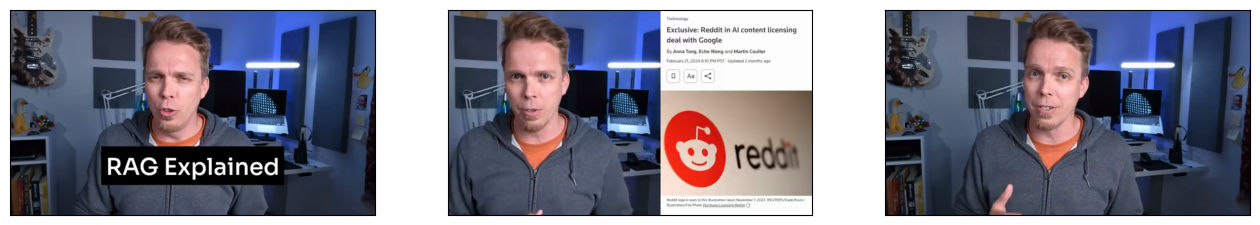

In [46]:
plot_images(img)

In [47]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [48]:
img

['/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data/frame0000.png',
 '/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data/frame0001.png',
 '/Users/sidharthrao/Documents/Documents - Sidharth’s MacBook Pro/GitHub/Project-Dash/2. GenAI and AgenticAI/ii. Class Sessions/e. RAG/multimodal_rag_data/mixed_data/frame0008.png']

In [49]:
import json
metadata_str=json.dumps(metadata_vid)

In [50]:
query_str="can you tell me what is RAG?"

In [51]:
context_str = "".join(text)

In [52]:
image_documents = SimpleDirectoryReader( input_files=img).load_data()

In [53]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [54]:
# openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500)
if not OPENAI_AVAILABLE:
    raise RuntimeError("OpenAI key is not available; cannot instantiate OpenAIMultiModal.")
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o",
    api_key=OPENAI_API_TOKEN,
    max_new_tokens=1500,
)


/var/folders/79/t61hnkts0vd9nddl0ll19c_80000gn/T/ipykernel_28204/2586984357.py:4: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(


In [55]:
# result=openai_mm_llm.complete(
#     prompt=qa_tmpl_str.format(
#         query_str=query_str,metadata_str=metadata_str
#     ),
#     image_documents=image_documents,
# )

result=openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
    query_str=query_str,
    metadata_str=metadata_str,
    context_str=context_str  # ← Add this
),
  image_documents=image_documents,
)




ValueError: Unsupported content block type: ImageDocument

In [ ]:
pprint(result.text)

In [ ]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)